In [26]:
from alntk.alignment import import_from_fasta, get_unaligned_seqs, get_compact_alignment, write_to_fasta
from alntk.plotting import default_plot_style

In [27]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
color_cycle = default_plot_style()
data_folder = '../data/'

# Retain only sequences that have amino acids in the positions of reference sequences

We say in the `02_compact_iterative` analysis that by choosing a threshold of 0.95 after four iterations we preserve most of the sequences that we are interested in (`P80219 DDN1_BOVIN`, `P00772 CELA1_PIG`, `P00763 TRY2_RAT`, `P00766 CTRA_BOVIN`). However the `P00734 THRB_HUMAN` is eliminated always in the first round, whichever the threshold. I have tried also to lower the threshold on the percentage of amino acids that are allowed in a sequence in "unusual positions", but as soon as the `THRB_HUMAN` sequence is included we loose convergence to a distribution with low amount of highly gapped columns.

So I thought of constraining the selection of sequences just to those which have amino acids in the union of positions of the reference sequences.

In [4]:
new_aln_descs, new_aln_seqs = import_from_fasta(data_folder + 'new_aln.faa')
np.random.seed(42)
subsample_mask = np.random.randint(0, len(new_aln_descs), size=10_000)
subaln_seqs = new_aln_seqs[subsample_mask]
subaln_descs = new_aln_descs[subsample_mask]

In [5]:
subaln_seqs.shape

(10000, 693)

In [6]:
important_sequences_idx = [7105, 14901, 16943, 18287, 46064]

In [7]:
important_aa_mask = np.sum(new_aln_seqs[important_sequences_idx] != '-', axis=0) > 0

In [8]:
sequences_to_be_kept = np.sum(new_aln_seqs[:, ~important_aa_mask] != '-', axis=1) == 0

In [9]:
refproc_seqs = new_aln_seqs[sequences_to_be_kept][:, important_aa_mask]
refproc_descs = new_aln_descs[sequences_to_be_kept]

# Compare results in iterative and reference scheme

## Positions

In [10]:
iterative_pos = np.array([0,1,2,3,35,36,37,38,39,40,82,83,84,85,86,87,88,89,90,91,92,93,94,110,111,112,113,114,115,116,117,118,119,120,121,122,129,130,131,132,133,134,147,148,149,150,151,152,153,154,155,156,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,280,281,282,283,307,308,309,310,311,312,313,333,334,335,336,337,338,352,353,354,355,356,357,358,359,360,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,399,400,401,421,422,423,424,425,430,431,433,434,435,436,437,438,439,440,441,469,470,471,472,473,474,475,476,477,478,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,520,521,522,523,524,525,526,527,528,530,531,532,533,534,535,536,537,538,544,545,546,547,548,549,550,551,552,553,554,555,556,557,563,564,565,566,567,568,569,575,576,577,578,579,580,581,582,583,584,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605])

In [11]:
reference_pos = np.where(important_aa_mask == True)[0]

In [12]:
len(iterative_pos), len(reference_pos)

(260, 270)

In [13]:
set(iterative_pos) - set(reference_pos)

{360, 538}

In [14]:
set(reference_pos) - set(iterative_pos)

{157, 158, 159, 351, 383, 384, 517, 518, 519, 542, 543, 606}

## Sequences

In [15]:
iter_descs, iter_seqs = import_from_fasta(data_folder + 'iter.faa')

In [16]:
len(set(refproc_descs) - set(iter_descs))

3030

In [17]:
len(set(iter_descs) - set(refproc_descs))

5306

In [18]:
len(set(iter_descs).union(set(refproc_descs)))

23500

In [19]:
len(set(iter_descs).intersection(set(refproc_descs)))

15164

In [20]:
3030/(15164+3030), 5306/(15164+5306)

(0.1665384192590964, 0.2592085979482169)

In the iterative procedure there are many more sequences rather than in the reference procedure with respect to their intersection. However in any case they respectively account for 16% (iterative) and 26% (reference) of each set.

In [24]:
iter_idx_wrt_subaln = []
refproc_idx_wrt_subaln = []
for i, d in enumerate(subaln_descs):
    if d in refproc_descs:
        refproc_idx_wrt_subaln.append(i)
    if d in iter_descs:
        iter_idx_wrt_subaln.append(i)

In [31]:
ohe = OneHotEncoder(handle_unknown='ignore')
subaln_seqs_ohe = ohe.fit_transform(subaln_seqs)

pca = PCA(n_components=2, svd_solver='arpack')
pca.fit(subaln_seqs_ohe)
subaln_pca = pca.transform(subaln_seqs_ohe)

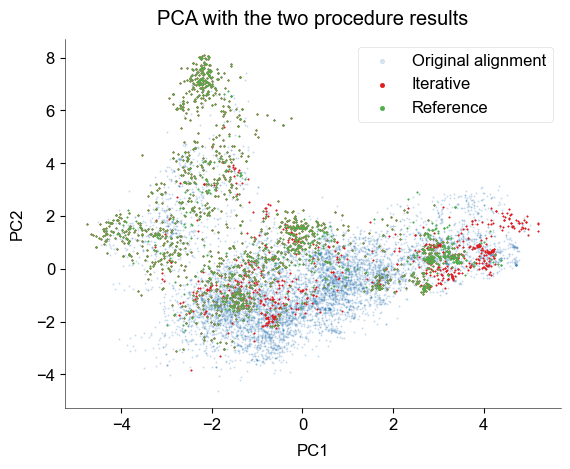

In [34]:
fig, ax = plt.subplots()
ax.set_title('PCA with the two procedure results')
ax.scatter(subaln_pca[:, 0], subaln_pca[:, 1], s=1, alpha=.2, label='Original alignment')
ax.scatter(subaln_pca[iter_idx_wrt_subaln, 0], subaln_pca[iter_idx_wrt_subaln, 1], s=1, label='Iterative')
ax.scatter(subaln_pca[refproc_idx_wrt_subaln, 0], subaln_pca[refproc_idx_wrt_subaln, 1], s=1, label='Reference')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
lgd = plt.legend()
for handle in lgd.legend_handles:
    handle.set_sizes([10])
plt.show()